<a href="https://www.kaggle.com/code/a7medragab11/microsoft-stock-price-prediction-lstm?scriptVersionId=252425661" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

## 📋 Project Overview

This project implements an **LSTM (Long Short-Term Memory)** neural network for **stock price prediction**. The model addresses the challenge of **multicollinearity** between OHLC (Open, High, Low, Close) features while leveraging **temporal patterns** in stock market data.

---

### 🎯 Problem Statement

Stock market features (`Open`, `High`, `Low`, `Close`) are **highly correlated**, which can lead to:

- Multicollinearity in traditional linear models  
- Redundant information in feature space  
- Overfitting due to feature redundancy  

---

### ✅ Solution Approach

- Leverage **LSTM's** ability to handle correlated features through **non-linear transformations**  
- Compare **single-feature vs. multi-feature** approaches  
- Implement **feature engineering** to extract meaningful patterns  

---

### 📊 Dataset Description

#### 🔧 Features

| Feature | Description                  | Type     |
|---------|------------------------------|----------|
| Date    | Trading date                 | Datetime |
| Open    | Opening price                | Float    |
| High    | Highest price of the day     | Float    |
| Low     | Lowest price of the day      | Float    |
| Close   | Closing price (**Target**)   | Float    |
| Volume  | Number of shares traded      | Integer  |

---

### 📌 Data Characteristics

- **Temporal Nature**: Time series data with daily frequency  
- **High Correlation**: `Open`, `High`, `Low` are highly correlated with `Close` (typically >0.95)  
- **Non-stationary**: Prices typically show trends over time


## Dependencies

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from statsmodels.graphics.tsaplots import plot_acf
import seaborn as sns
import re
import os

# TensorFlow, sklearn and NLP tools
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
classification_report, confusion_matrix, accuracy_score, 
mean_squared_error, mean_absolute_error, r2_score)
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.layers import (
Embedding, LSTM, Dense, Activation, Bidirectional, Dropout, GRU, 
SimpleRNN, BatchNormalization, AlphaDropout, LayerNormalization)

2025-07-25 11:28:50.652852: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753442930.873027      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753442930.936453      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Configuration Parameters

In [2]:
LOOKBACK_DAYS = 60  
TRAIN_SPLIT = 0.8
BATCH_SIZE = 32
EPOCHS = 50   

## Data Preprocessing

In [3]:
df = pd.read_csv('/kaggle/input/nyse/prices.csv')

In [4]:
df.head()

,date,symbol,open,close,low,high,volume
0,2016-01-05 00:00:00,WLTW,123.430000,125.839996,122.309998,126.250000,2163600.0
1,2016-01-06 00:00:00,WLTW,125.239998,119.980003,119.940002,125.540001,2386400.0
2,2016-01-07 00:00:00,WLTW,116.379997,114.949997,114.930000,119.739998,2489500.0
3,2016-01-08 00:00:00,WLTW,115.480003,116.620003,113.500000,117.440002,2006300.0
4,2016-01-11 00:00:00,WLTW,117.010002,114.970001,114.089996,117.330002,1408600.0


In [5]:
df.isna().sum()

date      0
symbol    0
open      0
close     0
low       0
high      0
volume    0
dtype: int64

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 851264 entries, 0 to 851263
Data columns (total 7 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   date    851264 non-null  object 
 1   symbol  851264 non-null  object 
 2   open    851264 non-null  float64
 3   close   851264 non-null  float64
 4   low     851264 non-null  float64
 5   high    851264 non-null  float64
 6   volume  851264 non-null  float64
dtypes: float64(5), object(2)
memory usage: 45.5+ MB


In [7]:
df.describe()

,open,close,low,high,volume
count,851264.000000,851264.000000,851264.000000,851264.000000,8.512640e+05
mean,70.836986,70.857109,70.118414,71.543476,5.415113e+06
std,83.695876,83.689686,82.877294,84.465504,1.249468e+07
min,0.850000,0.860000,0.830000,0.880000,0.000000e+00
25%,33.840000,33.849998,33.480000,34.189999,1.221500e+06
50%,52.770000,52.799999,52.230000,53.310001,2.476250e+06
75%,79.879997,79.889999,79.110001,80.610001,5.222500e+06
max,1584.439941,1578.130005,1549.939941,1600.930054,8.596434e+08


In [8]:
df.shape

(851264, 7)

In [9]:
print(df['symbol'].value_counts()[:20])

symbol
VTR     1762
VZ      1762
WAT     1762
WBA     1762
WDC     1762
WEC     1762
WFC     1762
WFM     1762
VFC     1762
VIAB    1762
VLO     1762
VMC     1762
VNO     1762
VRSK    1762
VRSN    1762
VRTX    1762
UNP     1762
UPS     1762
URBN    1762
URI     1762
Name: count, dtype: int64


In [10]:
new_df=df[df['symbol']=='MSFT']

In [11]:
new_df.head()

,date,symbol,open,close,low,high,volume
544,2010-01-04,MSFT,30.620001,30.950001,30.590000,31.100000,38409100.0
1012,2010-01-05,MSFT,30.850000,30.959999,30.639999,31.100000,49749600.0
1480,2010-01-06,MSFT,30.879999,30.770000,30.520000,31.080000,58182400.0
1948,2010-01-07,MSFT,30.629999,30.450001,30.190001,30.700001,50559700.0
2416,2010-01-08,MSFT,30.280001,30.660000,30.240000,30.879999,51197400.0


In [12]:
new_df.describe()

,open,close,low,high,volume
count,1762.000000,1762.000000,1762.000000,1762.000000,1.762000e+03
mean,37.110789,37.129841,36.788621,37.436754,4.579784e+07
std,10.796157,10.810695,10.725634,10.879890,2.428640e+07
min,23.090000,23.010000,22.730000,23.320000,8.409600e+06
25%,27.799999,27.840000,27.530001,28.002500,2.964580e+07
50%,32.930000,33.024999,32.670001,33.340000,4.086645e+07
75%,46.027499,46.107500,45.697501,46.527499,5.504572e+07
max,63.840000,63.619999,63.410000,64.099998,3.193179e+08


In [13]:
new_df.shape

(1762, 7)

In [14]:
new_df['date']=pd.to_datetime(new_df['date'])

/tmp/ipykernel_19/1993220123.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['date']=pd.to_datetime(new_df['date'])


In [15]:
print(f"Date from : {new_df['date'].min()} to : {new_df['date'].max()}")

Date from : 2010-01-04 00:00:00 to : 2016-12-30 00:00:00


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

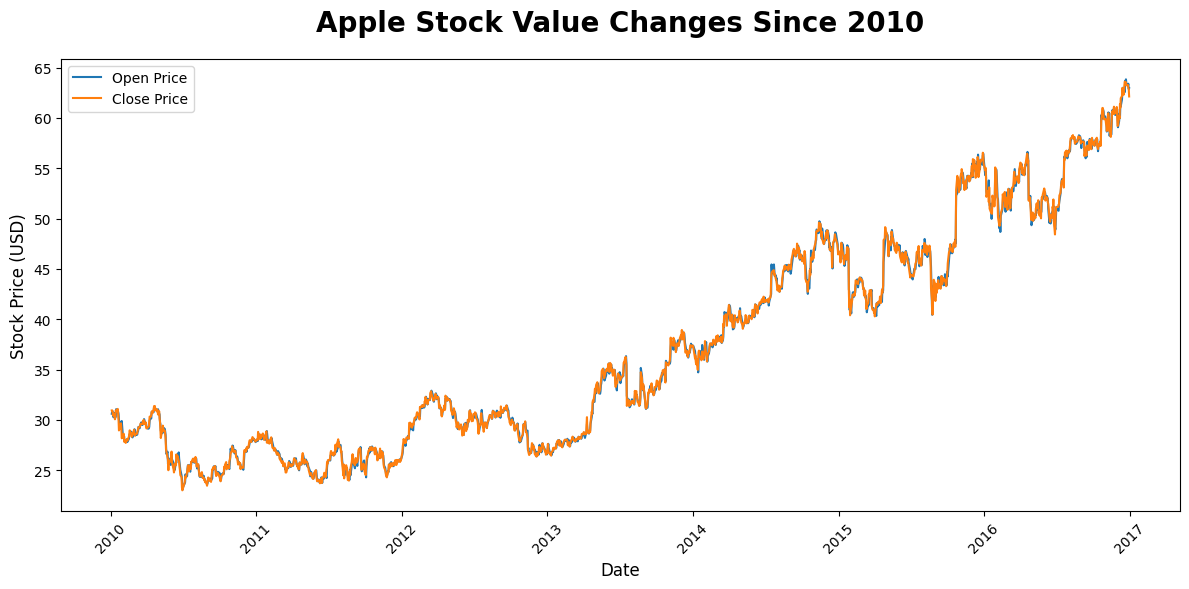

In [16]:
plt.figure(figsize=(12, 6))

# Plot open and close prices
sns.lineplot(data=new_df, x='date', y='open', label='Open Price')
sns.lineplot(data=new_df, x='date', y='close', label='Close Price')
plt.title("Apple Stock Value Changes Since 2010", fontsize=20, weight='bold', pad=20)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Stock Price (USD)", fontsize=12)
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

In [17]:
new_df.drop(['symbol'], axis=1, inplace=True)

/tmp/ipykernel_19/116546777.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop(['symbol'], axis=1, inplace=True)


In [18]:
new_df.corr()['close']

date      0.926278
open      0.999224
close     1.000000
low       0.999656
high      0.999650
volume   -0.461325
Name: close, dtype: float64

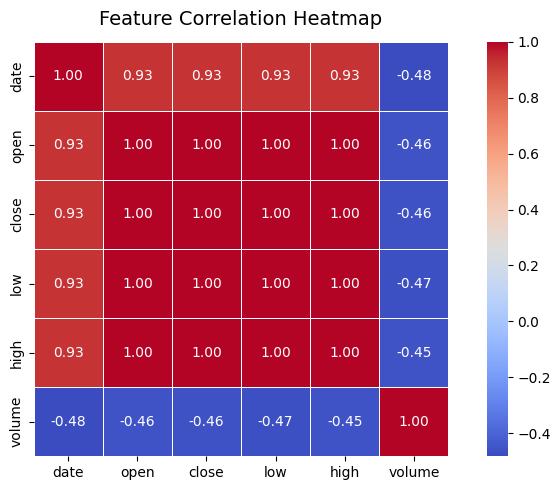

In [19]:
fig = plt.figure(figsize=(8,5))
sns.heatmap(
    new_df.corr(),
    annot=True, 
    fmt=".2f",   
    linewidths=0.5,
    cmap="coolwarm",
    square=True,   
)
plt.title("Feature Correlation Heatmap", fontsize=14, pad=12)
plt.tight_layout()
plt.show()

In [20]:
# def add_technical_indicators(df):
#     """Add optimized technical indicators for stock price analysis"""
    
#     # Ensure necessary columns exist
#     required_cols = {'open', 'high', 'low', 'close'}
#     if not required_cols.issubset(df.columns.str.lower()):
#         raise ValueError(f"Missing required columns: {required_cols - set(df.columns.str.lower())}")

#     # Ensure all column names are lowercase
#     df.columns = df.columns.str.lower()
    
#     # Price-based features
#     df['price_range'] = df['high'] - df['low']
    
#     # Returns
#     df['returns'] = df['close'].pct_change()
#     df['log_returns'] = np.log(df['close'] / df['close'].shift(1))
    
#     # Moving averages and signal
#     df['ma_5'] = df['close'].rolling(window=5).mean()
#     df['ma_20'] = df['close'].rolling(window=20).mean()
#     df['ma_signal'] = df['ma_5'] - df['ma_20']
#     return df.dropna()

In [21]:
def prepare_lstm_data(df, feature_cols, target_col, lookback):
    """Prepare sequences for LSTM input"""
    # Separate scalers for features and target
    scaler_features = MinMaxScaler()
    scaler_target = MinMaxScaler()
    
    # Scale data
    features_scaled = scaler_features.fit_transform(df[feature_cols])
    target_scaled = scaler_target.fit_transform(df[[target_col]])
    
    # Create sequences
    X, y = [], []
    for i in range(lookback, len(df)):
        X.append(features_scaled[i-lookback:i])
        y.append(target_scaled[i, 0])
    
    return np.array(X), np.array(y), scaler_features, scaler_target

In [22]:
def build_multi_feature_lstm(lookback, n_features):
    model = Sequential([
        LSTM(100, return_sequences=True, input_shape=(lookback, n_features)),
        Dropout(0.3),
        LSTM(100, return_sequences=True),
        Dropout(0.2),
        LSTM(50),
        Dropout(0.2),
        Dense(25),
        Dense(1)
    ])
    
    model.compile(optimizer='adam', loss='mse', metrics=['mae', 'mape'])
    return model

## Model Training

In [23]:
# 3. Add technical indicators
# df = add_technical_indicators(df)
# Prepare data
feature_cols = ['open', 'high', 'low']
target_col = 'close'

In [24]:
# Split data
train_size = int(len(new_df) * TRAIN_SPLIT)
train_df = new_df[:train_size]
test_df = new_df[train_size:]

# Prepare sequences
X_train, y_train, scaler_X, scaler_y = prepare_lstm_data(
    train_df, feature_cols, target_col, LOOKBACK_DAYS
)
X_test, y_test, _, _ = prepare_lstm_data(
    test_df, feature_cols, target_col, LOOKBACK_DAYS
)

# Build model Arch
model = build_multi_feature_lstm(LOOKBACK_DAYS, len(feature_cols))

callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=0.00001,
        verbose=1
    )
]

I0000 00:00:1753442946.368782      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1753442946.369547      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [25]:
# Train model
history = model.fit(
    X_train, y_train,
    batch_size=32,
    epochs=50,
    validation_split=0.1,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/50


I0000 00:00:1753442952.937923      64 cuda_dnn.cc:529] Loaded cuDNN version 90300


38/38 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - loss: 0.0362 - mae: 0.1221 - mape: 100234.9453 - val_loss: 0.0066 - val_mae: 0.0600 - val_mape: 7.6004 - learning_rate: 0.0010
Epoch 2/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0035 - mae: 0.0443 - mape: 77637.2031 - val_loss: 0.0062 - val_mae: 0.0569 - val_mape: 7.1757 - learning_rate: 0.0010
Epoch 3/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0036 - mae: 0.0449 - mape: 279012.7500 - val_loss: 0.0056 - val_mae: 0.0512 - val_mape: 6.2539 - learning_rate: 0.0010
Epoch 4/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0030 - mae: 0.0416 - mape: 65924.6328 - val_loss: 0.0061 - val_mae: 0.0553 - val_mape: 6.6651 - learning_rate: 0.0010
Epoch 5/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0033 - mae: 0.0412 - mape: 14451.5010 - val_loss: 0.0058 - val_mae: 0.0536 - val_mape: 6.4769 - learning_rate: 0.0010
Epoch 6/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0035 - mae: 0.0445 - mape: 149171.9062 - val_loss: 0.

## Evaluation

In [26]:
# Make predictions
train_pred = model.predict(X_train)
test_pred = model.predict(X_test)

# Inverse transform predictions
train_pred = scaler_y.inverse_transform(train_pred)
test_pred = scaler_y.inverse_transform(test_pred)
y_train_actual = scaler_y.inverse_transform(y_train.reshape(-1, 1))
y_test_actual = scaler_y.inverse_transform(y_test.reshape(-1, 1))

# Calculate metrics
train_mse = mean_squared_error(y_train_actual, train_pred)
test_mse = mean_squared_error(y_test_actual, test_pred)
train_mae = mean_absolute_error(y_train_actual, train_pred)
test_mae = mean_absolute_error(y_test_actual, test_pred)
train_r2 = r2_score(y_train_actual, train_pred)
test_r2 = r2_score(y_test_actual, test_pred)

43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


In [27]:
print(f" Training Metrics:")
print(f"  - MSE:  {train_mse:.6f}")
print(f"  - MAE:  {train_mae:.6f}")
print(f"  - R²:   {train_r2:.4f}")

print(f"\n Testing Metrics:")
print(f"  - MSE:  {test_mse:.6f}")
print(f"  - MAE:  {test_mae:.6f}")
print(f"  - R²:   {test_r2:.4f}")

 Training Metrics:
  - MSE:  0.641830
  - MAE:  0.582590
  - R²:   0.9886

 Testing Metrics:
  - MSE:  1.702857
  - MAE:  1.013826
  - R²:   0.8989


## Visualizations

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
MSE: 1.70
MAE: 1.01
R²: 0.8989


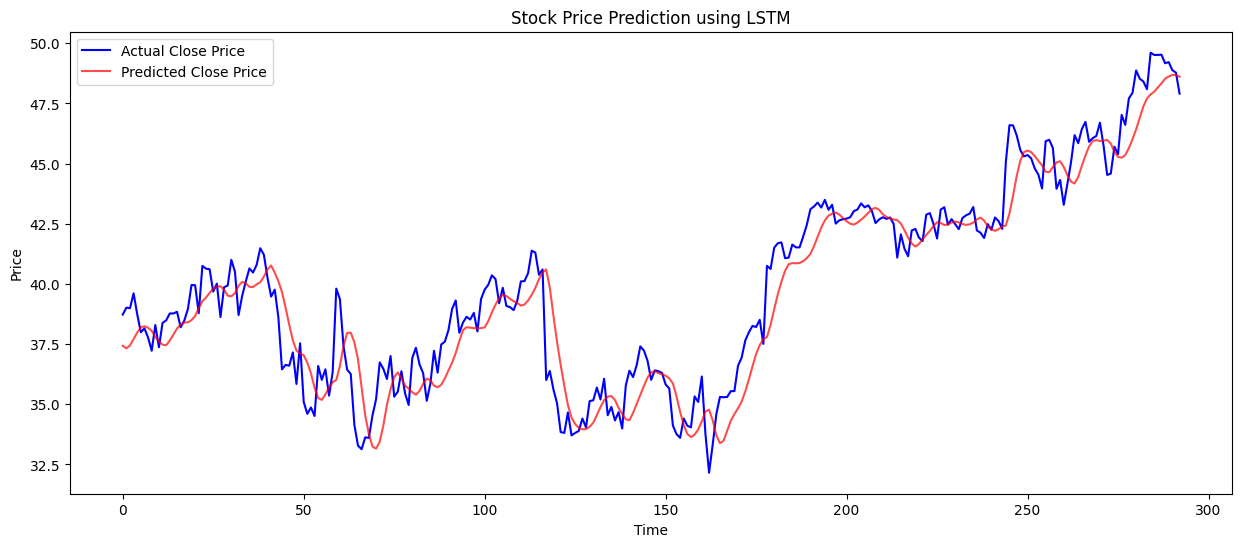

In [28]:
# Make predictions
predictions = model.predict(X_test)

# Inverse transform to get actual prices
predictions = scaler_y.inverse_transform(predictions)
actual = scaler_y.inverse_transform(y_test.reshape(-1, 1))

# Calculate metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

mse = mean_squared_error(actual, predictions)
mae = mean_absolute_error(actual, predictions)
r2 = r2_score(actual, predictions)

print(f"MSE: {mse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R²: {r2:.4f}")

# Visualize results

plt.figure(figsize=(15, 6))
plt.plot(actual, label='Actual Close Price', color='blue')
plt.plot(predictions, label='Predicted Close Price', color='red', alpha=0.7)
plt.title('Stock Price Prediction using LSTM')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

In [29]:
pred=model.predict(X_test)
test=pd.DataFrame(columns=['test','pred'])
test['test']=y_test
test['pred']=pred.flatten()
test

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


,test,pred
0,0.590929,0.542145
1,0.601728,0.538125
2,0.600864,0.542755
3,0.624190,0.552517
4,0.591361,0.562858
...,...,...
288,0.983585,0.959418
289,0.985313,0.962855
290,0.972786,0.965286
291,0.968899,0.965233


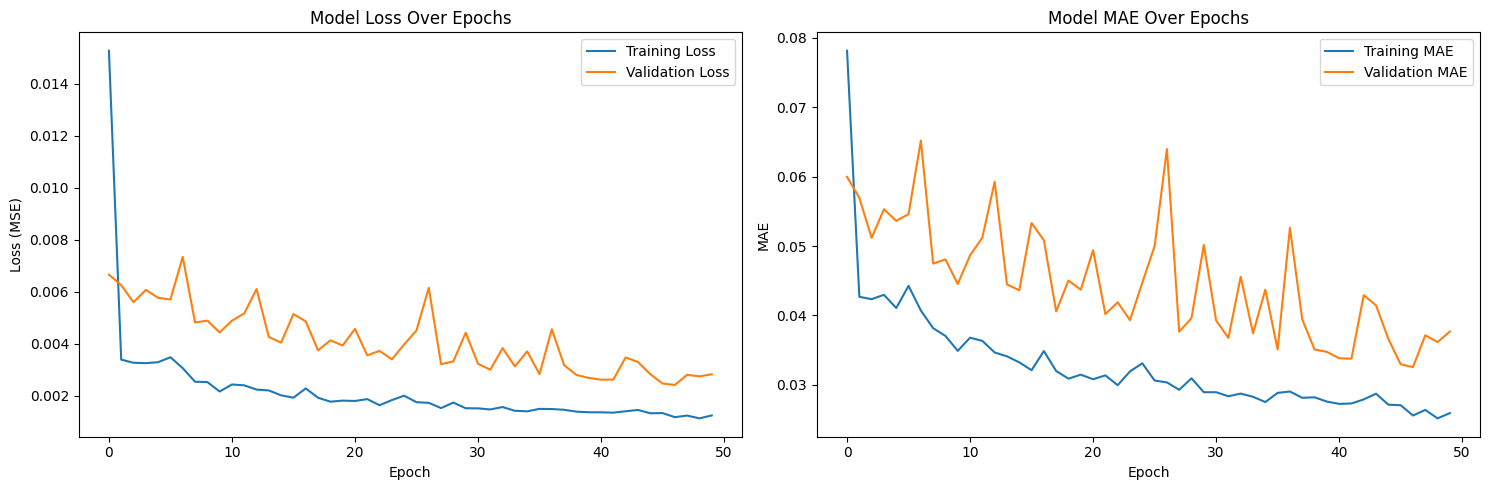

In [30]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Loss plot
axes[0].plot(history.history['loss'], label='Training Loss')
axes[0].plot(history.history['val_loss'], label='Validation Loss')
axes[0].set_title('Model Loss Over Epochs')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss (MSE)')
axes[0].legend()

# MAE plot
axes[1].plot(history.history['mae'], label='Training MAE')
axes[1].plot(history.history['val_mae'], label='Validation MAE')
axes[1].set_title('Model MAE Over Epochs')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('MAE')
axes[1].legend()

plt.tight_layout()
plt.show()

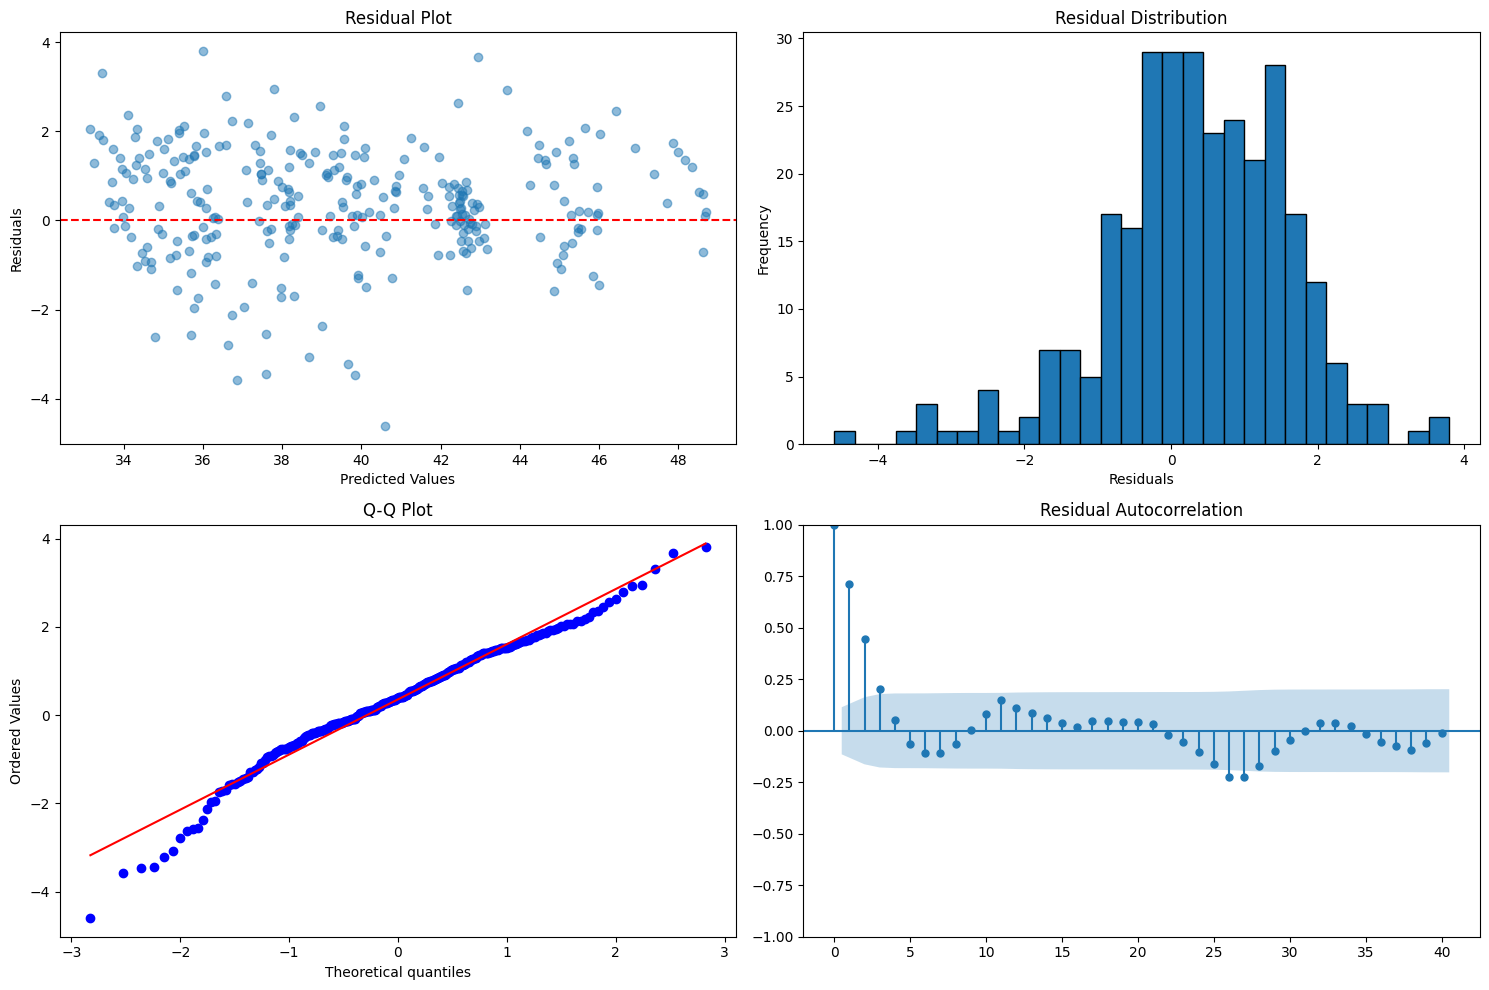

In [31]:
residuals = y_test_actual.flatten() - test_pred.flatten()

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Residual plot
axes[0, 0].scatter(test_pred, residuals, alpha=0.5)
axes[0, 0].axhline(y=0, color='r', linestyle='--')
axes[0, 0].set_xlabel('Predicted Values')
axes[0, 0].set_ylabel('Residuals')
axes[0, 0].set_title('Residual Plot')

# Histogram of residuals
axes[0, 1].hist(residuals, bins=30, edgecolor='black')
axes[0, 1].set_xlabel('Residuals')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('Residual Distribution')

# Q-Q plot
stats.probplot(residuals, dist="norm", plot=axes[1, 0])
axes[1, 0].set_title('Q-Q Plot')

# Autocorrelation of residuals
plot_acf(residuals, lags=40, ax=axes[1, 1])
axes[1, 1].set_title('Residual Autocorrelation')

plt.tight_layout()
plt.show()

In [32]:
# Analyze feature importance using permutation
def analyze_feature_importance(model, X_test, y_test, feature_names):
    baseline_mae = mean_absolute_error(
        y_test, 
        model.predict(X_test)
    )
    
    importances = []
    for i in range(X_test.shape[2]):
        X_test_permuted = X_test.copy()
        np.random.shuffle(X_test_permuted[:, :, i])
        
        permuted_mae = mean_absolute_error(
            y_test,
            model.predict(X_test_permuted)
        )
        importance = permuted_mae - baseline_mae
        importances.append(importance)
    
    # Plot importance
    plt.figure(figsize=(10, 6))
    plt.barh(feature_names, importances)
    plt.xlabel('Increase in MAE when feature is permuted')
    plt.title('Feature Importance Analysis')
    plt.tight_layout()
    plt.show()
    
    return importances

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


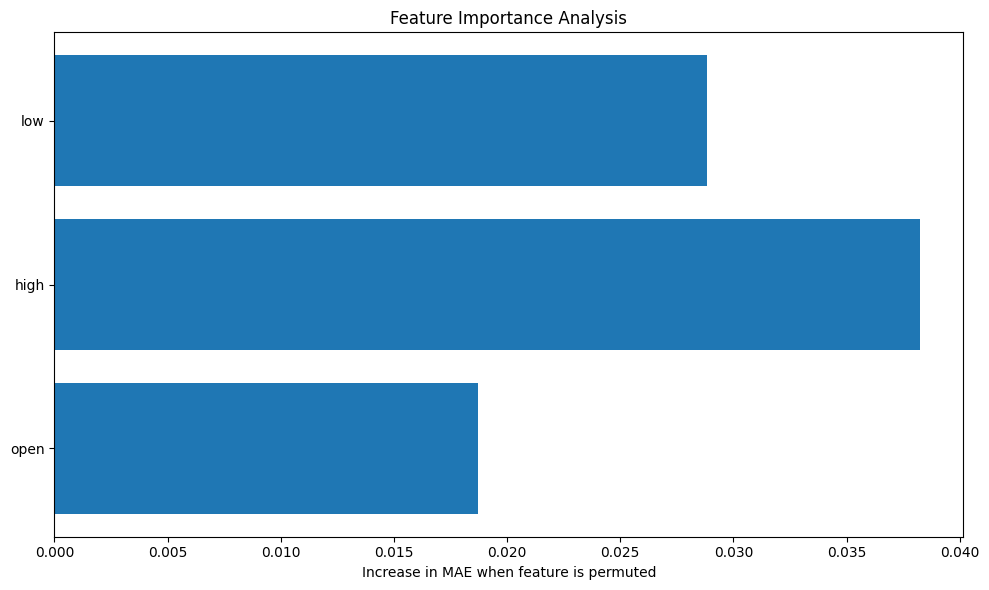

[0.018730446634560284, 0.03823868674582919, 0.02883764902445444]

In [33]:
analyze_feature_importance(model, X_test, y_test, feature_cols)